### 각 날짜의 1시간 전의 기상상황을 활용 하여 따릉이 대여수를 예측해보기

In [162]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [54]:
# 데이터 불러오기
train = pd.read_csv('../data/train.csv') # 모델 학습 데이터
test = pd.read_csv('../data/test.csv')   # 모델 테스트 데이터
submission = pd.read_csv('../data/submission.csv')   # 제출지

display(train.head())
display(test.head())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


#### 서울시 마포구의 날짜별, 시간별 기상상황과 따릉이 대여 수 데이터
column
* id 고유 id
* hour 시간
* temperature 기온
* precipitation 비가 오지 않았으면 0, 비가 오면 1
* windspeed 풍속(평균)
* humidity 습도
* visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* ozone 오존
* pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* count 시간에 따른 따릉이 대여 수


In [55]:
print(train.shape)
print(test.shape)

# train 정보 확인
train.info()
print("=" * 60)
# test 정보 확인
test.info()

(1459, 11)
(715, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column               

* 기술통계량
    * count : 해당 column에서 비어 있지 않은 값의 개수
    * mean : 평균
    * std : 표준편차
    * min : 최솟값(이상치 포함)
    * max : 최댓값(이상치 포함)

In [56]:
# train 셋의 요약 정보 확인
display(train.describe())

print("=" * 60)

# test 셋의 요약 정보 확인
display(test.describe())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,715.000000,714.000000,714.000000,714.000000,714.000000,714.000000,680.000000,678.000000,679.000000
mean,1056.854545,11.472727,23.263305,0.051821,2.388515,56.668067,1359.494398,0.041196,36.930678,24.939617
std,625.574471,6.928427,4.039645,0.221820,1.171270,19.661880,614.171870,0.020656,12.641503,10.075857
min,0.000000,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000
25%,507.000000,5.500000,20.300000,0.000000,1.500000,42.000000,807.250000,0.027000,28.000000,17.000000
50%,1046.000000,11.000000,22.900000,0.000000,2.300000,55.000000,1489.000000,0.039000,35.000000,24.000000
75%,1616.500000,17.000000,26.375000,0.000000,3.275000,73.750000,2000.000000,0.052250,45.000000,31.000000
max,2177.000000,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000


In [57]:
# 시간별로 group시켜서 확인
train.groupby('hour').mean()

,id,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
hour,,,,,,,,,,
0,1200.016667,14.788136,0.016949,1.965517,58.169492,1434.220339,0.033763,55.881356,30.982759,71.766667
1,1074.918033,14.155738,0.049180,1.836667,60.459016,1400.852459,NaN,NaN,NaN,47.606557
2,1077.885246,13.747541,0.049180,1.633333,61.721311,1374.278689,0.030492,58.475410,31.366667,31.409836
3,1146.704918,13.357377,0.032787,1.620000,63.131148,1326.311475,0.031213,59.180328,31.466667,21.377049
4,1194.786885,13.001639,0.016393,1.409836,64.573770,1264.606557,0.031984,58.278689,32.116667,13.524590
5,1091.819672,12.673770,0.016393,1.296721,66.000000,1203.426230,0.031623,56.721311,31.525424,13.114754
6,1112.393443,12.377049,0.016393,1.331148,67.409836,1146.229508,0.029317,56.150000,31.603448,24.557377
7,1086.262295,12.191803,0.016393,1.262295,67.934426,1150.311475,0.025300,56.533333,31.779661,62.360656
8,1086.491803,12.600000,0.032787,1.632787,64.049180,1152.868852,0.021197,57.918033,31.796610,136.688525


"\n'count'와 의미있는 상관관계를 보이는 애들\n\nhour 시간\ntemperature 기온\nwindspeed 풍속(평균)\nhumidity 습도\nvisibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)\nozone 오존\ncount 시간에 따른 따릉이 대여 수\n"

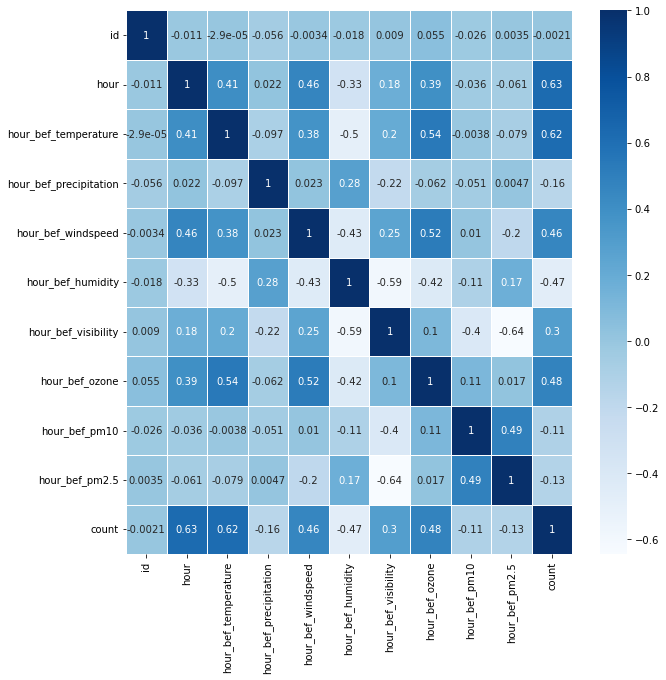

In [58]:
# heatmap으로 상관관계 확인해보기

plt.figure(figsize=(10,10))
sns.heatmap(data = train.corr(), annot=True, linewidths=.5, cmap='Blues')
'''
'count'와 의미있는 상관관계를 보이는 애들

hour 시간
temperature 기온
windspeed 풍속(평균)
humidity 습도
visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
ozone 오존
count 시간에 따른 따릉이 대여 수
'''

'\n출퇴근 시간에 대여량이 늘어나는 것이 보임\n'

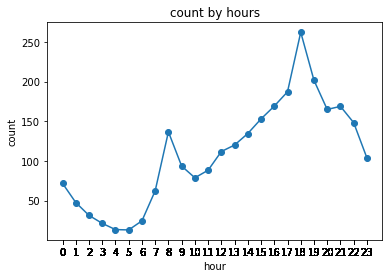

In [59]:
plt.plot(train.groupby('hour').mean()['count'],
         'o-')

plt.xticks(ticks=train['hour'])
plt.title('count by hours')
plt.xlabel('hour')
plt.ylabel('count')
'''
출퇴근 시간에 대여량이 늘어나는 것이 보임
'''

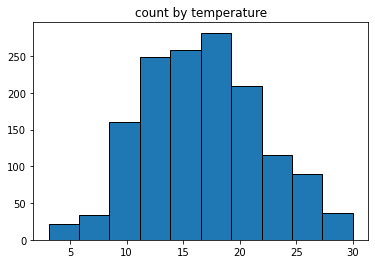

'\n10도 ~ 20도 사이에 빈도수가 높은 것을 확인\n'

In [60]:
plt.hist(train['hour_bef_temperature'],
         edgecolor='black')
plt.title('count by temperature')
plt.show()

'''
10도 ~ 20도 사이에 빈도수가 높은 것을 확인
'''

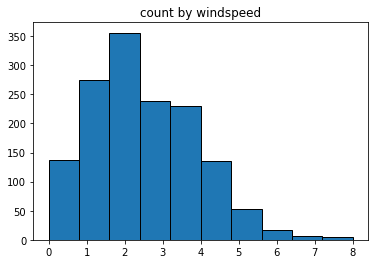

'\n5이상의 풍속이 불때, 빈도수가 낮아짐\n'

In [61]:
plt.hist(train['hour_bef_windspeed'],
         edgecolor='black')
plt.title('count by windspeed')
plt.show()

'''
5이상의 풍속이 불때, 빈도수가 낮아짐
'''

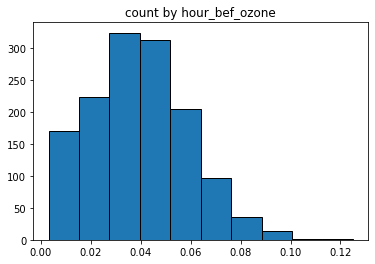

'\n오존 주의보 기준이 0.12ppm 이상임\n0.07부터 빈도수가 줄어드는 것을 확인할 수 있음\n'

In [62]:
plt.hist(train['hour_bef_ozone'],
         edgecolor='black')
plt.title('count by hour_bef_ozone')
plt.show()

'''
오존 주의보 기준이 0.12ppm 이상임
0.07부터 빈도수가 줄어드는 것을 확인할 수 있음
'''

#### 데이터 전처리

In [63]:
# 사용하지 않는 컬럼 드랍
'''
hour 시간
temperature 기온
windspeed 풍속(평균)
humidity 습도
visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
ozone 오존
count 시간에 따른 따릉이 대여 수
'''
train.drop(['hour_bef_pm10','hour_bef_pm2.5'], axis=1, inplace=True)
display(train.head())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,431.0


In [64]:
# 결측치 확인
print(train.isna().sum())
print(train.isna().sum().sum())

# 결측치 비율
#train.isnull().sum() / len(train)*100

id                         0
hour                       0
hour_bef_temperature       2
hour_bef_precipitation     2
hour_bef_windspeed         9
hour_bef_humidity          2
hour_bef_visibility        2
hour_bef_ozone            76
count                      0
dtype: int64
93


In [65]:
#train.groupby('hour').mean()
ozone_1hour = (0.033763 + 0.030492)/2
print(ozone_1hour)

0.0321275


In [66]:
# 시간별 평균으로 결측치 대체
fill_mean_hour = lambda x: x.fillna(x.mean())
train = train.groupby('hour').apply(fill_mean_hour)

In [67]:
# hour_bef_ozone 1시는 0시와 2시의 평균값으로 대체
train['hour_bef_ozone'] = train['hour_bef_ozone'].fillna(0.0321275)

In [68]:
train.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
count                     0
dtype: int64

In [69]:
test.isna().sum()

id                         0
hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [70]:
test.drop(['hour_bef_pm10','hour_bef_pm2.5'], axis=1, inplace=True)
display(test.head())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041


In [27]:
#test[test['hour_bef_ozone'].isnull()]

In [71]:
# train set의 평균치로 채워줌
test['hour_bef_ozone'] = test['hour_bef_ozone'].fillna(0.0321275)
display(test.head())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041


In [73]:
fill_mean_hour = lambda x: x.fillna(x.mean())
test = test.groupby('hour').apply(fill_mean_hour)
test.isna().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
dtype: int64

#### 정규화

In [74]:
# Min-max Scaling

# train
def min_max(s):
    return (s - s.min()) / (s.max() - s.min())

train_MinMax = train.apply(min_max, axis=0)

display(train_MinMax.head())

print("=" * 100)

# test
test_MinMax = test.apply(min_max, axis=0)

display(test_MinMax.head())

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,count
0,0.000000,0.869565,0.490706,1.0,0.1875,0.891304,0.259105,0.196721,0.111628
1,0.001379,0.565217,0.631970,0.0,0.1750,0.445652,0.436004,0.319672,0.367442
2,0.001838,0.260870,0.401487,0.0,0.0875,0.782609,0.678460,0.245902,0.058140
3,0.002298,1.000000,0.185874,0.0,0.3375,0.510870,0.451613,0.303279,0.130233
4,0.002757,0.782609,0.981413,0.0,0.6000,0.000000,1.000000,0.442623,1.000000


,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone
0,0.000000,0.304348,0.317708,0.0,0.220339,0.547619,0.441836,0.281481
1,0.000459,0.739130,0.802083,0.0,0.915254,0.202381,0.781217,0.429630
2,0.000919,0.565217,0.229167,1.0,0.355932,0.940476,0.035752,0.125926
3,0.001837,0.260870,0.411458,0.0,0.423729,0.523810,0.565101,0.177778
4,0.002297,0.956522,0.000000,1.0,0.576271,0.916667,0.049093,0.281481


#### 표준화

In [116]:
# Standard Sacler // train
feature_names = ['id','hour','hour_bef_temperature','hour_bef_precipitation','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility',
                 'hour_bef_ozone','count']

train_standadized_skl = StandardScaler().fit_transform(train)

train_standadized = pd.DataFrame(data=train_standadized_skl, columns=feature_names)

In [118]:
# Standard Sacler // test
feature_names = ['id','hour','hour_bef_temperature','hour_bef_precipitation','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility',
                 'hour_bef_ozone']

test_standadized_skl = StandardScaler().fit_transform(test)

test_standadized = pd.DataFrame(data=test_standadized_skl, columns=feature_names)

In [117]:
display(train_standadized)

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,count
0,-1.747545,1.229190,-0.080035,5.542292,-0.711998,1.806803,-1.423666,-0.624442,-0.721077
1,-1.742791,0.217691,0.645826,-0.180565,-0.784729,-0.207705,-0.840026,0.160388,0.610587
2,-1.741207,-0.793809,-0.538473,-0.180565,-1.293845,1.315459,-0.040096,-0.310510,-0.999516
3,-1.739622,1.662690,-1.646366,-0.180565,0.160773,0.087101,-0.788528,0.055744,-0.624228
4,-1.738038,0.940191,2.441376,-0.180565,1.688121,-2.222213,1.020756,0.945218,3.903430
...,...,...,...,...,...,...,...,...,...
1454,1.692359,-1.082809,0.015473,-0.180565,-0.639267,0.037966,1.020756,-0.415154,-1.060046
1455,1.693944,-1.227309,-1.130623,-0.180565,0.960812,-0.355108,1.020756,0.003422,-1.072152
1456,1.695528,-0.938309,0.301997,-0.180565,-0.421074,0.087101,1.020756,-1.566238,-1.047940
1457,1.698697,1.373690,0.760435,-0.180565,0.888081,-0.748183,-0.017780,2.253267,1.300632


In [91]:
train.corr()['count']

id                       -0.002131
hour                      0.626047
hour_bef_temperature      0.618222
hour_bef_precipitation   -0.163724
hour_bef_windspeed        0.459692
hour_bef_humidity        -0.470337
hour_bef_visibility       0.298538
hour_bef_ozone            0.481104
count                     1.000000
Name: count, dtype: float64

### 변수 선택 및 모델 구축

In [129]:
# X(features)를 model에 입력 받았을때, Y(count)를 산출하는 것

features = ['hour', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility', 'hour_bef_ozone']

# model 학습할때 사용되는 놈!
X_train = train_standadized[features] 
y_train = train_standadized['count']

# model 테스트할때 사용되는 놈!
X_test = test_standadized[features]

In [135]:
# RandomForest  => 의사결정나무가 모여서 숲으로!! 두둥! 😮
# n_estimators => 나무 개수
# max_depth => 모델의 과대적합을 방지하기 위해 주는 값 // ??🤔

model100 = RandomForestRegressor(n_estimators=100, random_state=0)
model100_5 = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0)
model100_10 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
model200 = RandomForestRegressor(n_estimators=200)

In [136]:
# 학습시켜버리기
model100.fit(X_train, y_train)
model100_5.fit(X_train, y_train)
model100_10.fit(X_train, y_train)
model200.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [137]:
ypred1 = model100.predict(X_test)
ypred2 = model100_5.predict(X_test)
ypred10 = model100_10.predict(X_test)
ypred3 = model200.predict(X_test)

In [138]:
print(submission.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(715, 2)
(1459, 6)
(1459,)
(715, 6)


In [134]:
submission['count']=ypred1
submission.to_csv('model100_3.csv', index = False)
#display(submission)

In [127]:
submission['count']=ypred2
#submission.to_csv('model100_5_2.csv', index = False)

In [125]:
submission['count']=ypred3
#submission.to_csv('model200_2.csv', index = False)

In [140]:
submission['count']=ypred10
submission.to_csv('model100_10.csv', index = False)

1. 1시에 오존값은 왜 다 비어있지?? => 그래서 0시 2시의 평균값으로 채웠음 => 이럴게 아니라 그냥 ozone 컬럼을 없앨걸 그랬어
2. 점수가 너무 낮음...  n_estimators=100 이 제일 낮은데,, 제일 낮은 점수가 164.6285160982 ㅎ...  
=> train 셋의 결측치는 시간별 평균으로 채워주고, test 셋은 컬럼별 평균으로 채웠음  
  오존량이 문제였나..?  
3. 표준화 / 정규화 아직 잘 모루겠습미다 😥  
4.랜덤 포레스트 그래프 그려보고싶었는데 😥